In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance):
        #store attributes
        self.target_mean = target_mean
        self.target_variance = target_variance
        
        #sample initial random effects
        random_effects = np.random.randn(g.n_chr, g.n_loci)
        #calculate the founder_population mean and var given these effects
        founder_scores = np.array([random_effects @ x.haplotype for x in population.individuals])
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        #scale the random effects to match our target variance
        scaling_factors = np.sqrt(self.target_variance / founder_var)
        random_effects *= scaling_factors
        self.effects = random_effects
        
        self.intercept = target_mean - founder_mean
        
    def __matmul__(self,other):
        if isinstance(other,Individual):
            return self.effects * other.haplotype + self.intercept
        elif isinstance(other, Population):
            return np.sum(np.array([self @ ind + self.intercept for ind in other.individuals]), axis=(1,2))
        
class Population:
    def __init__(self, genome, size):
        self.genome = genome
        self.size = size
        self.ploidy = 2
        self.individuals = self._create_initial_population()

    def _create_initial_population(self):
        """Create an initial population of founder individuals."""
        return [Individual(self.genome) for _ in range(self.size)]
    
    def get_haplo(self):
        return np.array([x.haplotype for x in self.individuals])

    def __repr__(self):
        return f'Population of size: {self.size}'
    
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance):
        #store attributes
        self.target_mean = target_mean
        self.target_variance = target_variance
        
        #sample initial random effects
        random_effects = np.random.randn(g.n_chr, g.n_loci)
        #calculate the founder_population mean and var given these effects
        
        founder_scores = np.einsum('ij,kij->k',random_effects, np.sum(population.get_haplo(),axis=1))
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        #scale the random effects to match our target variance
        scaling_factors = np.sqrt(self.target_variance / founder_var)
        random_effects *= scaling_factors
        self.effects = random_effects
        
        self.intercept = target_mean - founder_mean
        
    def __matmul__(self,other):
        if isinstance(other,Individual):
            return self.effects * other.haplotype
        elif isinstance(other, Population):
            return np.sum(np.array([self @ ind for ind in other.individuals]), axis=(1,2,3))
        
class Individual:
    def __init__(self, genome,haplotype=None, mother = None, father = None, descendants = 0, source='founder'):
        self.genome = genome  # must be Genome class
        self.haplotype = None
        self.source = source  # 'founder', 'cross', 'self', 'dh'
        self.descendents = []
        self.fitness = 0

        
        # Logic for setting haplotype,mother,father
        if self.source == 'founder':
            self.haplotype= self._generate_random_haplotype()
            self.mother = None
            self.father = None
        elif self.source == 'cross':
            self.haplotype = haplotype
            self.mother = mother
            self.father = father
        elif self.source == 'dh' or self.source == 'self':
            self.haplotype = haplotype
            self.mother = mother
            self.father = mother
        else:
            raise ValueError(f"Invalid source: {source}")
        
    def __repr__(self):
        return f'Individual with haplotype shape: {self.haplotype.shape}'

    def _generate_random_haplotype(self):
        """Generate a random haplotype for the individual."""
        return np.random.choice([0, 1], size=(self.genome.ploidy, self.genome.n_chr, self.genome.n_loci))
    
    def phenotype(self, chewc):
        chewc.trait @ np.sum(self.haplotype,axis=0)
        #np.sum(chewc.population.individuals[0]
        print('ok')
    
    def gametes(self):
        haplotypes = self.haplotype
        def shuffle_chr(chromosome_pair):
            """
            Perform crossover on a pair of chromosomes.

            Parameters:
            chromosome_pair (list): A list of two equal length lists representing chromosomes.

            Returns:
            list: A new chromosome formed by shuffling the given chromosome pair.
            """
            # Ensure the chromosome pair contains two chromosomes of equal length
            assert len(chromosome_pair) == 2
            assert len(chromosome_pair[0]) == len(chromosome_pair[1])

            # Number of crossover points, sampled from a Poisson distribution with λ=1.3
            n_crossover = np.random.poisson(1.3)

            # Determine crossover locations, sampled without replacement from chromosome length
            chromosome_length = len(chromosome_pair[0])
            crossover_locs = np.sort(np.random.choice(chromosome_length, n_crossover, replace=False))

            # Initialize the new chromosome and set the current chromosome to the first one
            new_chromosome = []
            current_chr = 0

            # Perform crossover by alternating segments between the two chromosomes
            last_loc = 0
            for loc in crossover_locs:
                new_chromosome.extend(chromosome_pair[current_chr][last_loc:loc])
                current_chr = 1 - current_chr  # Switch to the other chromosome
                last_loc = loc

            # Append the remaining segment
            new_chromosome.extend(chromosome_pair[current_chr][last_loc:])
            return np.array(new_chromosome)


        # Initialize an empty array to store the shuffled chromosomes
        shuffled_haplotypes = np.zeros_like(haplotypes)
        ploidy, n_chr, n_loci = chewc.genome.shape
        # Iterate over each chromosome and apply the shuffle_chr function
        for i in range(haplotypes.shape[1]):  # Iterate over the chromosomes
            chromosome_pair = haplotypes[:, i, :]  # Extract the chromosome pair (2, 77)
            shuffled_chromosome = shuffle_chr(chromosome_pair)  # Shuffle the chromosome pair    
            shuffled_haplotypes[:, i, :] = np.array(shuffled_chromosome).reshape(1, n_loci)  # Store the shuffled chromosome
        return shuffled_haplotypes[0,:,:]
    
class ChewC:
    def __init___(self):
        self.trait = None
        self.genome = None
        self.population = None

        # Example usage
g = Genome(3, 77)
#make population with 100 founder individuals
population = Population(g, size=100)
#make a trait
trait = Trait(g, population,0,1)
# how to do trait @ population to get the trait values for a population?

chewc = ChewC()
chewc.trait = trait
chewc.population = population
chewc.genome = g

In [ ]:
indi = chewc.population.individuals[0].haplotype ; indi.shape

(2, 3, 77)

In [ ]:
chewc.population.individuals[0].haplotype.shape

(2, 3, 77)

In [ ]:
chewc.population.individuals[0].phenotype(chewc)

ok


In [ ]:
%%timeit
chewc.population.individuals[0].gametes()

97 µs ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


(array([ 1.,  2., 11., 24., 52., 67., 35., 22., 12.,  5.]),
 array([-0.30689585, -0.2498311 , -0.19276634, -0.13570159, -0.07863684,
        -0.02157208,  0.03549267,  0.09255742,  0.14962218,  0.20668693,
         0.26375168]),
 <BarContainer object of 10 artists>)

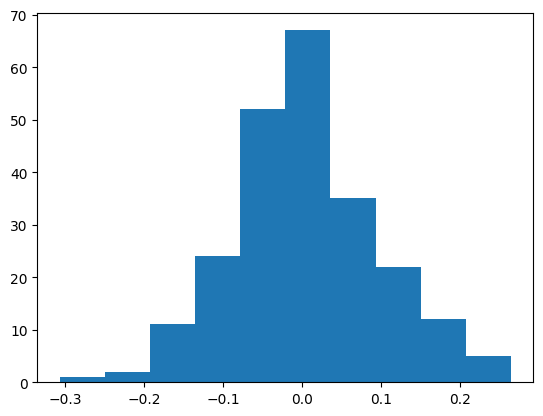

In [ ]:
plt.hist(trait.effects.flatten())